In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection,metrics
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#Import datasets,test.csv and train.csv
test=pd.read_csv('C:/Users/kongy/Documents/Python Scripts/Datasets/Kaggle-Titanic Dataset/test.csv',dtype={'Age':np.float64})
train=pd.read_csv('C:/Users/kongy/Documents/Python Scripts/Datasets/Kaggle-Titanic Dataset/train.csv',dtype={'Age':np.float64})
PassengerId=test['PassengerId']
all_data=pd.concat([train,test],ignore_index=True)

Variable Description
Survived: Survived (1) or died (0); this is the target variable
Pclass: Passenger's class (1st, 2nd or 3rd class)
Name: Passenger's name
Sex: Passenger's sex
Age: Passenger's age
SibSp: Number of siblings/spouses aboard
Parch: Number of parents/children aboard
Ticket: Ticket number
Fare: Fare
Cabin: Cabin
Embarked: Port of embarkation

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.info()
#We realize that some has missing values, Age(714/891), 
#Cabin(204/891) and Embarked(889/891)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
#Split datasets into X and Y, for which Y is Survived
X=train.loc[:,['Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
y=train[['Survived']]

Survived females:74.20%
Survived males:18.89%


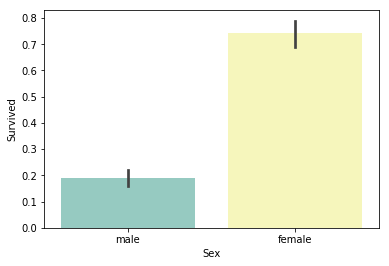

In [7]:
#Data Visualization
#Analyze on sex, we find out that female has much higher survival rate than male
sns.barplot(x='Sex',y='Survived',data=train,palette='Set3')
print('Survived females:{:.2f}%'.format(train['Survived'][train['Sex']=='female'].value_counts(normalize=True)[1]*100))
print('Survived males:{:.2f}%'.format(train['Survived'][train['Sex']=='male'].value_counts(normalize=True)[1]*100))

1st Class who survived:62.96%
2nd Class who survived:47.28%
3rd Class who survived:24.24%


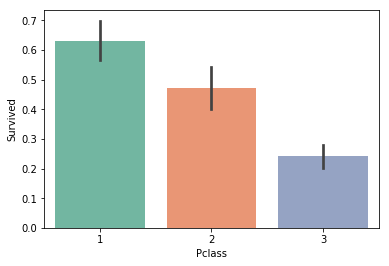

In [8]:
#Look at the relationship between Pclass and survival rate, we find out that the higher the class, the higher the survival rate 
sns.barplot(x='Pclass',y='Survived',data=train,palette='Set2')
print('1st Class who survived:{:.2f}%'.format(train['Survived'][train['Pclass']==1].value_counts(normalize=True)[1]*100))
print('2nd Class who survived:{:.2f}%'.format(train['Survived'][train['Pclass']==2].value_counts(normalize=True)[1]*100))
print('3rd Class who survived:{:.2f}%'.format(train['Survived'][train['Pclass']==3].value_counts(normalize=True)[1]*100))

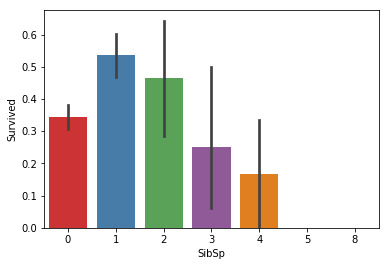

In [9]:
#Passengers with moderated number of siblings and spouse have higher survival rate
sns.barplot(x='SibSp',y='Survived',data=train,palette='Set1')

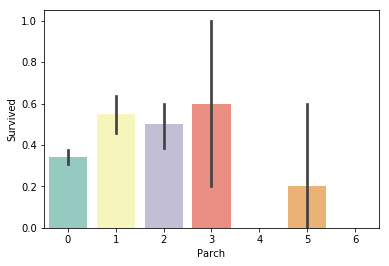

In [10]:
#Passengers with moderate number of parents and children have higher survival rate
sns.barplot(x='Parch',y='Survived',data=train,palette='Set3')

In [11]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


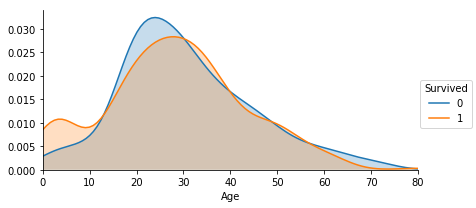

In [12]:
#Relationship between age and survival rate
#The two lines represent Survived 1, 0
facet=sns.FacetGrid(train,hue='Survived',aspect=2)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train['Age'].max()))
facet.add_legend()

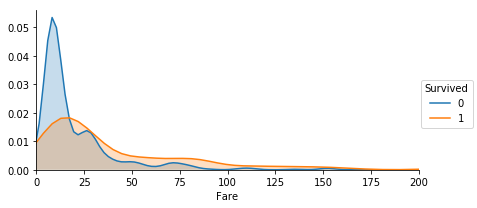

In [13]:
facet=sns.FacetGrid(train,hue='Survived',aspect=2)
facet.map(sns.kdeplot,'Fare',shade=True)
facet.set(xlim=(0,200))
facet.add_legend()

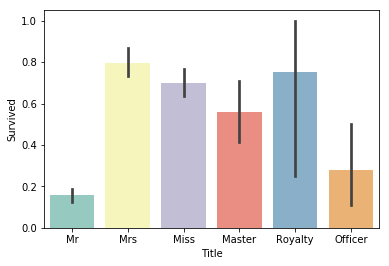

In [14]:
#We add New feature, title, different passengers have different titles, and different survival rate
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x="Title", y="Survived", data=all_data, palette='Set3')

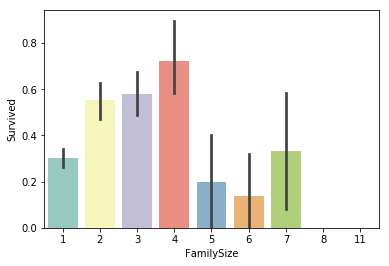

In [15]:
#New feature called 'FamilyLabel'
#First calculate FamilySize=Parch+SibSp+1, then divide FamilySize into three categories
#FamilySize between 2 and 4 have higher survival rate
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x='FamilySize',y='Survived',data=all_data,palette='Set3')

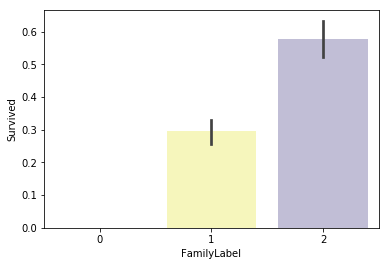

In [16]:
#Categorize FamilySize into 3 groups according to survival rate, which creates FamilyLabel
def fam_label(s):
    if (s>=2)&(s<=4):
        return 2
    elif (s==1)|((s>4)&(s<=7)):
        return 1
    elif (s>7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(fam_label)
sns.barplot(x='FamilyLabel',y='Survived',data=all_data,palette='Set3')

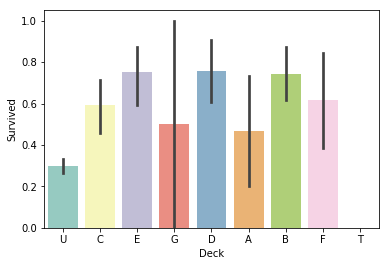

In [17]:
#New feature,'Deck',passengers from different deck have different survival rate
all_data['Cabin']=all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x='Deck',y='Survived',data=all_data,palette='Set3')

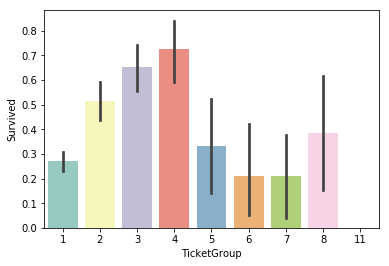

In [18]:
#New feature,'TicketGroup',summarize number of tickers of each passenger
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

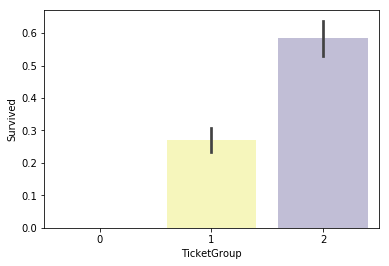

In [19]:
#Summarize TicketGroup into 3 groups
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

In [20]:
#Now we start data cleaning
#Fill in missed values
#Age has the most missed values, build a random forest model using 3 features, Pclass, Sex, Title,to fill in missed values of Age
age_df=all_data[['Age', 'Pclass','Sex','Title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[ (all_data.Age.isnull()), 'Age' ] = predictedAges 

In [21]:
#Now we fill in missed values in Embarked, the number of missed values is 2
#When we look into these two missed values, most of the information are identical
all_data[all_data.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,1,1,B,2
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,1,1,B,2


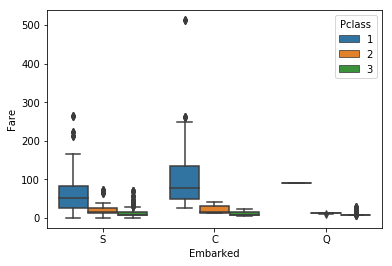

In [22]:
#Pclass of the passenger of the missed Embarked value=1, Fare=80, since median of Fare of passengers with Embarked=C and Pclass=1 is 80, we fill in value C 
sns.boxplot(x='Embarked',y='Fare',hue='Pclass',data=all_data)

In [23]:
all_data['Embarked']=all_data['Embarked'].fillna('C')

In [24]:
#Fill in missed value in Fare, number of missed value=1
#Embarked of the passenger with missed Fare value is S, Pclass is 3, therefore we fill in the missed value with median of passengers with Embarked=S AND Pclass=3
all_data[all_data.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FamilySize,FamilyLabel,Deck,TicketGroup
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Mr,1,1,U,1


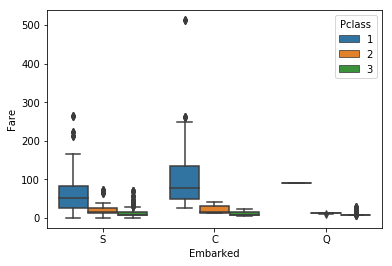

In [25]:
sns.boxplot(x='Embarked',y='Fare',hue='Pclass',data=all_data)

In [26]:
fare=all_data[(all_data['Embarked']=='S')&(all_data['Pclass']==3)].Fare.median()
all_data['Fare']=all_data['Fare'].fillna(fare)
#Complete missed values fill-in

In [28]:
#现在进行下一步，同组识别
#把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(all_data['Surname'].value_counts())
all_data['FamilyGroup'] = all_data['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=12) | (all_data['Sex']=='female'))]
Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>12) & (all_data['Sex']=='male')]

In [29]:
#发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
Female_Child

,GroupCount
1.000000,115
0.000000,31
0.750000,2
0.333333,1
0.142857,1


Text(0.5,0,'AverageSurvived')

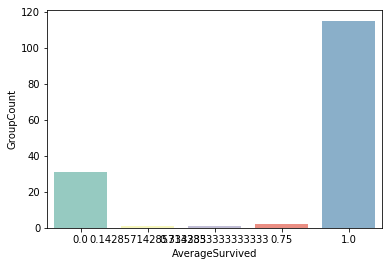

In [30]:
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"], palette='Set3').set_xlabel('AverageSurvived')

In [31]:
#Most male adult have average survival rate of 1 or 0
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


Text(0.5,0,'AverageSurvived')

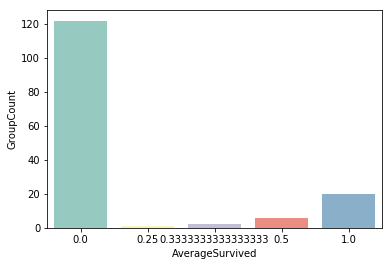

In [32]:
sns.barplot(x=Male_Adult.index, y=Male_Adult['GroupCount'], palette='Set3').set_xlabel('AverageSurvived')

In [33]:
#因为普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。
#把女性和儿童组中幸存率为0的组设置为遇难组，把成年男性组中存活率为1的设置为幸存组，
#推测处于遇难组的女性和儿童幸存的可能性较低，处于幸存组的成年男性幸存的可能性较高。
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Arnold-Franchi', 'Johnston', 'Turpin', 'Danbom', 'Rosblom', 'Ilmakangas', 'Bourke', 'Goodwin', 'Rice', 'Panula', 'Ford', 'Olsson', 'Canavan', 'Robins', 'Sage', 'Attalah', 'Jussila', 'Palsson', 'Caram', 'Lefebre', 'Barbara', 'Skoog', 'Strom', 'Van Impe', 'Lobb', 'Lahtinen', 'Zabour', 'Oreskovic', 'Cacic', 'Boulos', 'Vander Planke'}
{'Goldenberg', 'Cardeza', 'Jonsson', 'Daly', 'McCoy', 'Beane', 'Frolicher-Stehli', 'Beckwith', 'Dick', 'Duff Gordon', 'Frauenthal', 'Chambers', 'Greenfield', 'Jussila', 'Kimball', 'Bradley', 'Nakid', 'Taylor', 'Harder', 'Bishop'}


In [34]:
#为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改
train=all_data.loc[all_data['Survived'].notnull()]
test=all_data.loc[all_data['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

In [39]:
#Feature engineering
#Now we start feature transformation
#Choose features, transfer into dummy variables, split into training set and test set
all_data=pd.concat([train, test])
all_data=all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data=pd.get_dummies(all_data)
train=all_data[all_data['Survived'].notnull()]
test=all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X=train.as_matrix()[:,1:]
y=train.as_matrix()[:,0]

In [41]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X, y)
Y_pred = logreg.predict(test)
logreg.score(X, y)

0.8237934904601572

In [104]:
#get_dummies
df=pd.DataFrame({'key':['b','b','a','c','a','b'],'data1':range(6)})
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0
